<a href="https://colab.research.google.com/github/LHBuilder/SA-Segment-Anything/blob/main/integ_yolo_sam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Integrate YOLO-NAS and Meta SAM

Setup Environment

In [1]:
# py -3.10 -m venv myvenv
# myvenv\Scripts\activate

# !pip install super-gradients==3.1.0
# !pip install imutils
# !pip install pytube --upgrade

# !pip install git+https://github.com/facebookresearch/segment-anything.git

In [2]:
import torch
torch.__version__
torch.cuda.get_device_name(0)

/home/seeking/.conda/envs/SA2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'NVIDIA GeForce RTX 3060'

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from super_gradients.training import models as yolon

[2023-07-10 13:55:38] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/seeking/sg_logs/console.log


[2023-07-10 13:55:40] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-07-10 13:55:40] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-07-10 13:55:40] WARNING - export.py - Failed to import pytorch_quantization
[2023-07-10 13:55:40] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [4]:
def show_mask(mask, ax, random_color=False):
  if random_color:
    color = np.concatenate([np.random.random(3), np.array([0.6])], aixs=0)
  else:
    color = np.array([30/255, 144/255, 255/255, 0.6])
  h, w = mask.shape[-2:]
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
  ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
  pos_points = coords[labels==1]
  neg_points = coords[labels==0]
  ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=market_size, edgecolor='white', linewidth=1.25)
  ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=market_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
  x0, y0 = box[0], box[1]
  w, h = box[2] - box[0], box[3] - box[1]
  ax.add_patch(plt.Rectangle(x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

<function matplotlib.pyplot.show(close=None, block=None)>

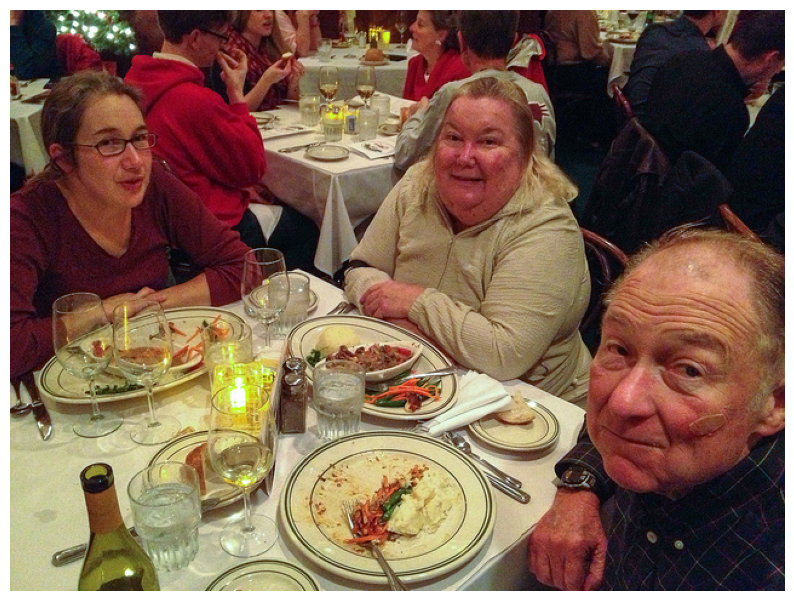

In [5]:
image = cv2.imread('temp/images/person.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')
plt.show

**YOLO-NAS Detects Objects**



[2023-07-10 13:55:46] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2023-07-10 13:55:46] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


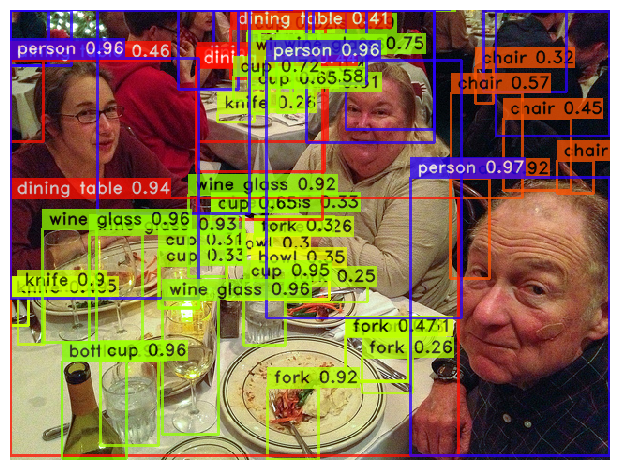

[2023-07-10 13:55:47] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [6]:

import cv2
import matplotlib.pyplot as plt
import pickle

image_path = 'temp/images/person.jpg'

model = yolon.get('yolo_nas_l', pretrained_weights='coco') # yolo_nas_l is the yolo_nas large model
detection_pred=model.predict(image, conf=0.25)
print(detection_pred[0].class_names)
detection_pred.show()
conf_threshold = 0.65
detection_pred = model.predict(image_path, conf=conf_threshold)

detections = detection_pred.save('temp/output_folder') # save the output with detected bounding box

**SAM Selects Objects**

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. And then run on CUDA and use the default model for best results

In [7]:
#!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [9]:
from segment_anything import sam_model_registry, SamPredictor
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import matplotlib.pyplot as plt
import cv2

image = cv2.imread('temp/images/person.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# SAM model for masking
sam_checkpoint = "temp/weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

#predictor = SamPredicator(sam)

mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)
plt.figure(figsize=(20,20))
plt.imshow(image)
print(len(masks))
show_anns(masks)
plt.axis('off')
plt.show()

189


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Now all the objects were masked but we only want to put mask on Person
Steps:
1. Object detection using YOLO-NAS
2. Provide bounding box coordinates to SAM
3. SAM will provide the mask on Person

YOLO-NAS inference: Extract confidence, labels, and bounding boxes
Access this information via the _images_prediction_lst attribute of the prediction objects.

In [1]:
from super_gradients.training import models as yolon
import cv2

image_path = 'temp/images/person.jpg'
model = yolon.get("yolo_nas_l", pretrained_weights="coco")
conf_threshold = 0.25

detection_pred = model.predict(image_path, conf = conf_threshold)._images_prediction_lst

/home/seeking/.conda/envs/SA2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2023-07-10 13:59:16] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /home/seeking/sg_logs/console.log


[2023-07-10 13:59:17] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-07-10 13:59:17] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-07-10 13:59:17] WARNING - export.py - Failed to import pytorch_quantization
[2023-07-10 13:59:17] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-07-10 13:59:18] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2023-07-10 13:59:18] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Extract only the desired information

In [2]:
# Extract desired outputs
bboxes_xyxy = detection_pred[0].prediction.bboxes_xyxy.tolist()
confidence = detection_pred[0].prediction.confidence.tolist()
labels = detection_pred[0].prediction.labels.tolist()

print("Bounding Boxes (xyxy):", bboxes_xyxy)
print("Confidence:", confidence)
print("Labels:", labels)

bboxes_xyxy,confidence,labels

([[427.00634765625, 178.5677490234375, 639.3778076171875, 475.5967102050781],
  [96.25481414794922,
   373.168212890625,
   158.65684509277344,
   464.26495361328125],
  [162.65623474121094,
   308.83099365234375,
   222.1952667236328,
   452.5312194824219],
  [273.04833984375, 53.03451919555664, 481.94580078125, 328.5776672363281],
  [34.78321838378906, 233.2322235107422, 92.45965576171875, 354.2796936035156],
  [0.5896456837654114,
   51.20530319213867,
   201.3499755859375,
   307.2467041015625],
  [55.89048767089844, 374.1510925292969, 124.4307632446289, 478.9356994628906],
  [93.40125274658203,
   0.29247739911079407,
   255.91000366210938,
   217.79129028320312],
  [249.01927185058594,
   288.36041259765625,
   293.712646484375,
   357.2035827636719],
  [0.49485310912132263,
   200.80677795410156,
   478.0824890136719,
   475.8858642578125],
  [84.53758239746094,
   239.6204071044922,
   141.40301513671875,
   360.54364013671875],
  [274.1067810058594, 402.334228515625, 329.54122

Bounding Boxes (xyxy): [[427.00634765625, 178.5677490234375, 639.3778076171875, 475.5967102050781], [96.25481414794922, 373.168212890625, 158.65684509277344, 464.26495361328125], [162.65623474121094, 308.83099365234375, 222.1952667236328, 452.5312194824219], [273.04833984375, 53.03451919555664, 481.94580078125, 328.5776672363281], [34.78321838378906, 233.2322235107422, 92.45965576171875, 354.2796936035156], [0.5896456837654114, 51.20530319213867, 201.3499755859375, 307.2467041015625], [55.89048767089844, 374.1510925292969, 124.4307632446289, 478.9356994628906], [93.40125274658203, 0.29247739911079407, 255.91000366210938, 217.79129028320312], [249.01927185058594, 288.36041259765625, 293.712646484375, 357.2035827636719], [0.49485310912132263, 200.80677795410156, 478.0824890136719, 475.8858642578125], [84.53758239746094, 239.6204071044922, 141.40301513671875, 360.54364013671875], [274.1067810058594, 402.334228515625, 329.5412292480469, 479.5372314453125], [190.64857482910156, 196.59727478

<function matplotlib.pyplot.show(close=None, block=None)>

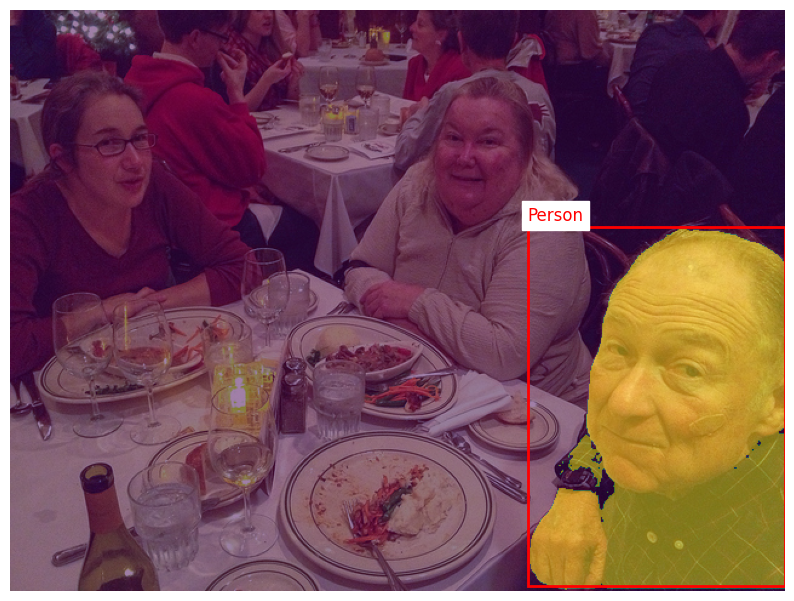

In [3]:
import sys
sys.path.append("..")
from super_gradients.training import models as yolon
from segment_anything import sam_model_registry, SamPredictor
import cv2
import matplotlib.pyplot as plt
import numpy as np

image_path = 'temp/images/person.jpg'
image = cv2.imread('temp/images/person.jpg')

# Display the image with masks and bounding box
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# SAM model for masking
sam_checkpoint = "temp/weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

predictor.set_image(image)

image = image.transpose((2, 0, 1)) # Tranpose to match SAM input format
image = image / 255.0 # Normalize image values to [0, 1]
image = np.expand_dims(image, axis=0) # Add batch dimension

input_box = np.array(bboxes_xyxy[0])

if labels[0] == 0:
  # predict masks using SAM
  masks, _, _ = predictor.predict(
      point_coords=None,
      point_labels=None,
      box=input_box[None, :],
      multimask_output=False,
  )



if labels[0] == 0:
  plt.imshow(masks[0], alpha=0.5)
plt.gca().add_patch(plt.Rectangle((input_box[0], input_box[1]), input_box[2] - input_box[0], input_box[3] - input_box[1],
                                   linewidth=2, edgecolor='r', facecolor='none'))
plt.text(input_box[0], input_box[1] - 5, 'Person', fontsize=12, color='r', backgroundcolor='w')
plt.axis('off')
plt.savefig('temp/output_folder/output3.png')
plt.show